# gymnasium

https://pytorch.apachecn.org/2.0/tutorials/intermediate/reinforcement_q_learning/

In [1]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

#建立matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# 如果用GPU的话
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """保存转换"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # 使用一个元素调用以确定下一个动作，或者在优化期间使用一批
    # 返回 tensor([[left0exp,right0exp]...])。
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [5]:
# BATCH_SIZE 是从重播缓冲区采样的转换数量
# GAMMA 是前一节中提到的折扣因子
# EPS_START 是 epsilon 的起始值
# EPS_END 是 epsilon 的最终值
# EPS_DECAY 控制 epsilon 指数衰减的速率，数值越高意味着衰减越慢
# TAU 是目标网络的更新速率
# LR 是 ``AdamW`` 优化器的学习率
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# 从 gym 动作空间获取动作数量
n_actions = env.action_space.n
# 获取状态观察的数量
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1）将为每行的列返回最大值。max result的第二列是找到max元素的索引，因此我们选择预期回报较大的操作。
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 平均 100 次迭代画一次
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # 暂定一会等待屏幕更新
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [6]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # 转置批样本(有关详细说明，请参阅https://stackoverflow.com/a/19343/3343043）。这会将转换的批处理数组转换为批处理数组的转换。
    batch = Transition(*zip(*transitions))

    # 计算非最终状态的掩码并连接批处理元素(最终状态将是模拟结束后的状态）
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # 计算Q(s_t, a)-模型计算 Q(s_t)，然后选择所采取行动的列。这些是根据策略网络对每个批处理状态所采取的操作。
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # 计算下一个状态的V(s_{t+1})。非最终状态下一个状态的预期操作值是基于“旧”目标网络计算的；选择max(1)[0]的最佳奖励。这是基于掩码合并的，这样当状态为最终状态时，我们将获得预期状态值或0。
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # 计算期望 Q 值
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # 计算 Huber 损失
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # 优化模型
    optimizer.zero_grad()
    loss.backward()
    # 原地梯度裁剪
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


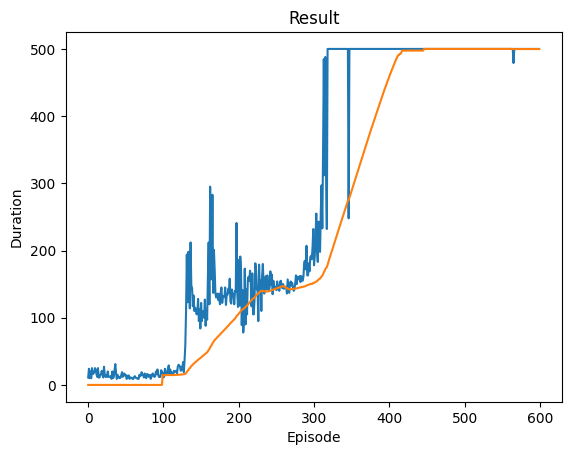

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # 初始化环境和状态
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # 在内存中储存当前参数
        memory.push(state, action, next_state, reward)

        # 进入下一状态
        state = next_state

        # 执行优化的一步（在策略网络上）
        optimize_model()

        # 目标网络权重的软更新
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()